In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xbpch
import cartopy.crs as ccrs
from matplotlib import colorbar, colors
import statistics
from sklearn.metrics import r2_score
from SiteLevels import levels
%matplotlib inline


/home/brittany/anaconda3/envs/geoschem/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/brittany/anaconda3/envs/geoschem/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Name the xbpch files for the reference and new models
OLD = '/home/brittany/Documents/HG/pythonHgBenchmark/trac_avg.geosfp_2x25_Hg.v12-01.bpch'
NEW = '/home/brittany/Documents/HG/pythonHgBenchmark/trac_avg.geosfp_2x25_Hg.v12-01.new.bpch'


# Upload/open the data from the models 
OLD_ds = (xbpch.open_bpchdataset(OLD))
NEW_ds = (xbpch.open_bpchdataset(NEW))
Dataset_OLD, Dataset_NEW= OLD_ds, NEW_ds

/home/brittany/anaconda3/envs/geoschem/lib/python3.6/site-packages/pandas/io/parsers.py:710: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


In [20]:
def LatitudinalGraphs(Dataset_OLD, Dataset_NEW):
    # Import the observed data from the sites     
    Hgobs = pd.read_csv('data/TGMSiteMonthly.csv',  skiprows=[0], na_values=(-9999))
    Hgobs.columns=['SiteID', 'Lat', 'Lon','Month', 'Year', 'Concentration', 'Standard deviation']
 


    # Make a variable for the unit conversion factor to obtain ng/m^3
    Unit_Conversion= 8.93
    # Make arrays of SiteIDs for the Arctic, Antarctic and Northern and Souther Mid Latitudes.
    Arctic=['ALT', 'VRS', 'ZEP', 'AND', 'PAL','AMD']
    Arctic = [e for e in Arctic if e in list(Hgobs.SiteID)]
    
    SouthMidLat=['CPT', 'AMS', 'BAR']
    SouthMidLat = [e for e in SouthMidLat if e in list(Hgobs.SiteID)]
    
    Antarctic= ['TRO', 'DDU', 'DMC']
    Antarctic = [e for e in Antarctic if e in list(Hgobs.SiteID)]
    
    NorthMidLat= ['MHD', 'UDH', 'KEJ',  'HTW', 'PNY', 'ATN', 'YKV', 'GRB','BIR', 'WAL', 'BRA', 'SAT', 'THOMPFARM', 'SCO', 'STIWELL', 'EBG'] 
    NorthMidLat = [e for e in NorthMidLat if e in list(Hgobs.SiteID)]
    
    
    
    # Create numpy zeros for the amount of items in each list.
    Arc_ds=np.zeros(len(Arctic))
    SML_ds=np.zeros(len(SouthMidLat))
    Ant_ds=np.zeros(len(Antarctic))
    NML_ds= np.zeros(len(NorthMidLat))


    # Select the list of numpy zeros for the Arctic and extract the data from each site, creating a new data.
    for i in range (len(Arctic)):
       

        Arc_ds= Hgobs[Hgobs.SiteID==Arctic[i]].reset_index()
   
        if i==0:

            All_Arctic_ds = Arc_ds

        else:

            All_Arctic_ds = pd.concat([All_Arctic_ds,Arc_ds])

    # Calculate the mean and stanadard deviation for each month.
    Arc_graph = All_Arctic_ds.groupby('Month').mean()
    Arc_graph_SD = All_Arctic_ds.groupby('Month').std() 
    # Select all unique latitudes and longitudes from the dataset.
    Arc_lat= All_Arctic_ds.Lat.unique()
    Arc_lon= All_Arctic_ds.Lon.unique()

    # Create a dataset for the total TGM at each site for the reference and new models.
    for i in range (len(Arctic)): 
        Arc_OLD_Hg0 =((Dataset_OLD['IJ_AVG_S_Hg0'].isel(lev=levels(Arctic[i]) ) * Unit_Conversion))                              
        Arc_OLD_Hg2 =((Dataset_OLD['IJ_AVG_S_Hg2'].isel(lev=levels(Arctic[i])) * Unit_Conversion) )               
        Arc_TGM_Old = (Arc_OLD_Hg0 + Arc_OLD_Hg2)
        Arc_OLD_mod= (Arc_TGM_Old.sel(lat=Arc_lat[i], lon=Arc_lon[i],  method='nearest'))
    
        Arc_NEW_Hg0 =((Dataset_NEW['IJ_AVG_S_Hg0'].isel(lev=levels(Arctic[i]) )) * Unit_Conversion)
        Arc_NEW_Hg2 =((Dataset_NEW['IJ_AVG_S_Hg2'].isel(lev=levels(Arctic[i]) )) * Unit_Conversion)
        Arc_TGM_New =( Arc_NEW_Hg0 + Arc_NEW_Hg2)
        Arc_NEW_mod= (Arc_TGM_New.sel(lat=Arc_lat[i], lon=Arc_lon[i],  method='nearest'))
        if i==0:

            Arc_DS_OLD = Arc_OLD_mod
            Arc_DS_NEW = Arc_NEW_mod
        else:

            Arc_DS_OLD= xr.concat([Arc_DS_OLD,Arc_OLD_mod])
            Arc_DS_NEW= xr.concat([Arc_DS_NEW,Arc_NEW_mod])
   # Calculate the mean and standard deviations for the reference and new models.
    Arc_meanmod_OLD=Arc_DS_OLD.mean('concat_dims')
    Arc_stdevmod_OLD= Arc_DS_OLD.std('concat_dims')
    
    Arc_meanmod_NEW= Arc_DS_NEW.mean('concat_dims')
    Arc_stdevmod_NEW= Arc_DS_NEW.std('concat_dims')
    

    

    # Select the list of numpy zeros for the South Mid Latitudes and extract the data from each site, creating a
    # new data.
    for i in range (len(SouthMidLat)):
        SML_ds= Hgobs[Hgobs.SiteID==SouthMidLat[i]].reset_index()
        if i==0:

            All_SML_ds = SML_ds

        else:

            All_SML_ds = pd.concat([All_SML_ds,SML_ds])
        
    # Calculate the mean and stanadard deviation for each month.        
    SML_graph = All_SML_ds.groupby('Month').mean()
    SML_graph_SD = All_SML_ds.groupby('Month').std()
    # Select all unique latitudes and longitudes from the dataset.
    SML_lat= All_SML_ds.Lat.unique()
    SML_lon= All_SML_ds.Lon.unique()
    
    # Create a dataset for the total TGM at each site for the reference and new models.    
    for i in range (len(SouthMidLat)): 
        SML_OLD_Hg0 =((Dataset_OLD['IJ_AVG_S_Hg0'].isel(lev=levels(SouthMidLat[i]) ) * Unit_Conversion))                              
        SML_OLD_Hg2 =((Dataset_OLD['IJ_AVG_S_Hg2'].isel(lev=levels(SouthMidLat[i])) * Unit_Conversion) )               
        SML_TGM_Old = (SML_OLD_Hg0 + SML_OLD_Hg2)
        SML_OLD_mod= (SML_TGM_Old.sel(lat=SML_lat[i], lon=SML_lon[i],  method='nearest'))
    
        SML_NEW_Hg0 =((Dataset_NEW['IJ_AVG_S_Hg0'].isel(lev=levels(SouthMidLat[i]) )) * Unit_Conversion)
        SML_NEW_Hg2 =((Dataset_NEW['IJ_AVG_S_Hg2'].isel(lev=levels(SouthMidLat[i]) )) * Unit_Conversion)
        SML_TGM_New =( SML_NEW_Hg0 + SML_NEW_Hg2)
        SML_NEW_mod= (SML_TGM_New.sel(lat=SML_lat[i], lon=SML_lon[i],  method='nearest'))
        if i==0:

            SML_DS_OLD = SML_OLD_mod
           # TGM_New_Arc= TGM_New
            SML_DS_NEW = SML_NEW_mod
        else:

            SML_DS_OLD= xr.concat([SML_DS_OLD,SML_OLD_mod])
            SML_DS_NEW= xr.concat([SML_DS_NEW,SML_NEW_mod])
    # Calculate the mean and standard deviations for the reference and new models.
    SML_meanmod_OLD=SML_DS_OLD.mean('concat_dims')
    SML_stdevmod_OLD= SML_DS_OLD.std('concat_dims')
    
    SML_meanmod_NEW= SML_DS_NEW.mean('concat_dims')
    SML_stdevmod_NEW= SML_DS_NEW.std('concat_dims')  
            

        
        
    # Select the list of numpy zeros for the Antarctic and extract the data from each site, creating a new data.    
    for i in range (len(Antarctic)):
        Ant_ds= Hgobs[Hgobs.SiteID==Antarctic[i]].reset_index()
        if i==0:

            All_Ant_ds = Ant_ds

        else:

            All_Ant_ds = pd.concat([All_Ant_ds,Ant_ds])    
    
    # Calculate the mean and stanadard deviation for each month.        
    Ant_graph = All_Ant_ds.groupby('Month').mean()
    Ant_graph_SD = All_Ant_ds.groupby('Month').std()
    # Select all unique latitudes and longitudes from the dataset.
    Ant_lat= All_Ant_ds.Lat.unique()
    Ant_lon= All_Ant_ds.Lon.unique()
    
    # Create a dataset for the total TGM at each site for the reference and new models.
    for i in range (len(Antarctic)): 
        Ant_OLD_Hg0 =((Dataset_OLD['IJ_AVG_S_Hg0'].isel(lev=levels(Antarctic[i]) ) * Unit_Conversion))                              
        Ant_OLD_Hg2 =((Dataset_OLD['IJ_AVG_S_Hg2'].isel(lev=levels(Antarctic[i])) * Unit_Conversion) )               
        Ant_TGM_Old = (Ant_OLD_Hg0 + Ant_OLD_Hg2)
        Ant_OLD_mod= (Ant_TGM_Old.sel(lat=Ant_lat[i], lon=Ant_lon[i],  method='nearest'))
    
        Ant_NEW_Hg0 =((Dataset_NEW['IJ_AVG_S_Hg0'].isel(lev=levels(Antarctic[i]) )) * Unit_Conversion)
        Ant_NEW_Hg2 =((Dataset_NEW['IJ_AVG_S_Hg2'].isel(lev=levels(Antarctic[i]) )) * Unit_Conversion)
        Ant_TGM_New =( Ant_NEW_Hg0 + Ant_NEW_Hg2)
        Ant_NEW_mod= (Ant_TGM_New.sel(lat=Ant_lat[i], lon=Ant_lon[i],  method='nearest'))
        if i==0:

            Ant_DS_OLD = Ant_OLD_mod
           # TGM_New_Arc= TGM_New
            Ant_DS_NEW = Ant_NEW_mod
        else:

            Ant_DS_OLD= xr.concat([Ant_DS_OLD,Ant_OLD_mod])
            Ant_DS_NEW= xr.concat([Ant_DS_NEW,Ant_NEW_mod])
            
    # Calculate the mean and standard deviations for the reference and new models.   
    Ant_meanmod_OLD=Ant_DS_OLD.mean('concat_dims')
    Ant_stdevmod_OLD= Ant_DS_OLD.std('concat_dims')
    
    Ant_meanmod_NEW= Ant_DS_NEW.mean('concat_dims')
    Ant_stdevmod_NEW= Ant_DS_NEW.std('concat_dims')
    
    
    
    
    
    
    
    
    # Select the list of numpy zeros for the North Mid Latitudes and extract the data from each site, creating a
    # new data.
    for i in range (len(NorthMidLat)):
        NML_ds= Hgobs[Hgobs.SiteID==NorthMidLat[i]].reset_index()
        if i==0:

            All_NML_ds = NML_ds

        else:

            All_NML_ds = pd.concat([All_NML_ds,NML_ds])

    
    # Calculate the mean and stanadard deviation for each month.        
    NML_graph = All_NML_ds.groupby('Month').mean()
    NML_graph_SD = All_NML_ds.groupby('Month').std()
    # Select all unique latitudes and longitudes from the dataset.
    NML_lat= All_NML_ds.Lat.unique()
    NML_lon= All_NML_ds.Lon.unique()
    
    # Create a dataset for the total TGM at each site for the reference and new models.    
    for i in range (len(NorthMidLat)): 
        NML_OLD_Hg0 =((Dataset_OLD['IJ_AVG_S_Hg0'].isel(lev=levels(NorthMidLat[i]) ) * Unit_Conversion))                              
        NML_OLD_Hg2 =((Dataset_OLD['IJ_AVG_S_Hg2'].isel(lev=levels(NorthMidLat[i])) * Unit_Conversion) )               
        NML_TGM_Old = (NML_OLD_Hg0 + NML_OLD_Hg2)
        NML_OLD_mod= (NML_TGM_Old.sel(lat=NML_lat[i], lon=NML_lon[i],  method='nearest'))
    
        NML_NEW_Hg0 =((Dataset_NEW['IJ_AVG_S_Hg0'].isel(lev=levels(NorthMidLat[i]) )) * Unit_Conversion)
        NML_NEW_Hg2 =((Dataset_NEW['IJ_AVG_S_Hg2'].isel(lev=levels(NorthMidLat[i]) )) * Unit_Conversion)
        NML_TGM_New =( NML_NEW_Hg0 + NML_NEW_Hg2)
        NML_NEW_mod= (NML_TGM_New.sel(lat=NML_lat[i], lon=NML_lon[i],  method='nearest'))
        if i==0:

            NML_DS_OLD = NML_OLD_mod
           # TGM_New_Arc= TGM_New
            NML_DS_NEW = NML_NEW_mod
        else:

            NML_DS_OLD= xr.concat([NML_DS_OLD,NML_OLD_mod])
            NML_DS_NEW= xr.concat([NML_DS_NEW,NML_NEW_mod])
            
    # Calculate the mean and standard deviations for the reference and new models.
    NML_meanmod_OLD=NML_DS_OLD.mean('concat_dims')
    NML_stdevmod_OLD= NML_DS_OLD.std('concat_dims')
    
    NML_meanmod_NEW= NML_DS_NEW.mean('concat_dims')
    NML_stdevmod_NEW= NML_DS_NEW.std('concat_dims')
    
    
    
 



        
    # Plot the four graphs as subplots.
    plt.figure(figsize=(20,10))
    
                                                # ARCTIC #
    # Convert the time data from a float to a string, specifying months for graph labels
    Arc_ds.index=pd.to_datetime(Arc_ds.Month, format='%m')
    # Add a subplot
    ax= plt.subplot(221)
    # Plot the observations and their error.
    plt.errorbar(Arc_ds.Month, Arc_graph.Concentration,yerr=Arc_graph_SD.Concentration, color='k')
    # Plot the reference and new models on the same graph with their errors.
    ax.errorbar(Arc_ds.Month,Arc_meanmod_OLD ,yerr=Arc_stdevmod_OLD, color='Blue')
    ax.errorbar(Arc_ds.Month, Arc_meanmod_NEW,yerr=Arc_stdevmod_NEW, color='Red')
    # Label the x and y axis. 
    plt.xlabel('Month')
    plt.ylabel('TGM (ng/m3)')
    # Add a legend
    plt.legend([ 'Observations','Reference Model','New Model' ])
    # Add a title.
    plt.title("Arctic")
    # Set ticks to every month 
    ax.set_xticks(Arc_ds.Month)
    # Set tick labels to month names
    ax.set_xticklabels(Arc_ds.index.strftime('%b'))
    
                                                # ANTARCTIC #    
    # Convert the time data from a float to a string, specifying months for graph labels
    Ant_ds.index=pd.to_datetime(Ant_ds.Month, format='%m')    
    # Add a subplot.
    ax= plt.subplot(222)
    # Plot the observations and their error.
    plt.errorbar(Ant_ds.Month, Ant_graph.Concentration,yerr=Ant_graph_SD.Concentration, color='k')
    # Plot the reference and new models on the same graph with their errors.
    ax.errorbar(Ant_ds.Month,Ant_meanmod_OLD ,yerr=Ant_stdevmod_OLD, color='Blue')
    ax.errorbar(Ant_ds.Month, Ant_meanmod_NEW,yerr=Ant_stdevmod_NEW, color='Red')
    # Label the x and y axis. 
    plt.xlabel('Month')
    plt.ylabel('TGM (ng/m3)')
    # Add a legend    
    plt.legend([ 'Observations','Reference Model','New Model' ])
    # Add a title.
    plt.title("Antarctic")
    # Set ticks to every month 
    ax.set_xticks(Ant_ds.Month)    
    # Set tick labels to month names
    ax.set_xticklabels(Ant_ds.index.strftime('%b'))
    
    
                                        # NORTHERN MID LATITUDES #     
    # Convert the time data from a float to a string, specifying months for graph labels
    NML_ds.index=pd.to_datetime(NML_ds.Month, format='%m')
    # Add a subplot. 
    ax= plt.subplot(223)
    # Plot the observations and their error.
    plt.errorbar(NML_ds.Month, NML_graph.Concentration,yerr=NML_graph_SD.Concentration, color='k')
    # Plot the reference and new models on the same graph with their errors.
    ax.errorbar(NML_ds.Month,NML_meanmod_OLD ,yerr=NML_stdevmod_OLD, color='Blue')
    ax.errorbar(NML_ds.Month, NML_meanmod_NEW,yerr=NML_stdevmod_NEW, color='Red')
    # Label the x and y axis.     
    plt.xlabel('Month')
    plt.ylabel('TGM (ng/m3)')
    # Add a legend
    plt.legend([ 'Observations','Reference Model','New Model' ])
    # Add a title.
    plt.title("Northern Mid Latitudes")
    # Set ticks to every month 
    ax.set_xticks(NML_ds.Month)
    # Set tick labels to month names
    ax.set_xticklabels(NML_ds.index.strftime('%b'))
    
                                        # SOUTHERN MID LATITUDES #     
    # Convert the time data from a float to a string, specifying months for graph labels
    SML_ds.index=pd.to_datetime(SML_ds.Month, format='%m')
    # Add a subplot.
    ax= plt.subplot(224)
    # Plot the observations and their error.
    plt.errorbar(SML_ds.Month, SML_graph.Concentration,yerr=SML_graph_SD.Concentration, color='k')
    # Plot the reference and new models on the same graph with their errors.
    ax.errorbar(SML_ds.Month,SML_meanmod_OLD ,yerr=SML_stdevmod_OLD, color='Blue')
    ax.errorbar(SML_ds.Month, SML_meanmod_NEW,yerr=SML_stdevmod_NEW, color='Red')
    # Label the x and y axis. 
    plt.xlabel('Month')
    plt.ylabel('TGM (ng/m3)')
    # Add a legend
    plt.legend([ 'Observations','Reference Model','New Model' ])
    # Add a title.
    plt.title("Southern Mid Latitudes")
    # Set ticks to every month 
    ax.set_xticks(SML_ds.Month)    
    # Set tick labels to month names
    ax.set_xticklabels(SML_ds.index.strftime('%b'))
  

    
    
     # Show the 4 subplots 
    LatGraph= plt.show()
    return LatGraph

/home/brittany/anaconda3/envs/geoschem/lib/python3.6/site-packages/ipykernel_launcher.py:70: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'
/home/brittany/anaconda3/envs/geoschem/lib/python3.6/site-packages/ipykernel_launcher.py:71: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'
/home/brittany/anaconda3/envs/geoschem/lib/python3.6/site-packages/ipykernel_launcher.py:119: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'
/home/brittany/anaconda3/envs/geoschem/lib/python3.6/site-packages/ipykernel_launcher.py:120: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'
/home/brittany/anaconda3/envs/

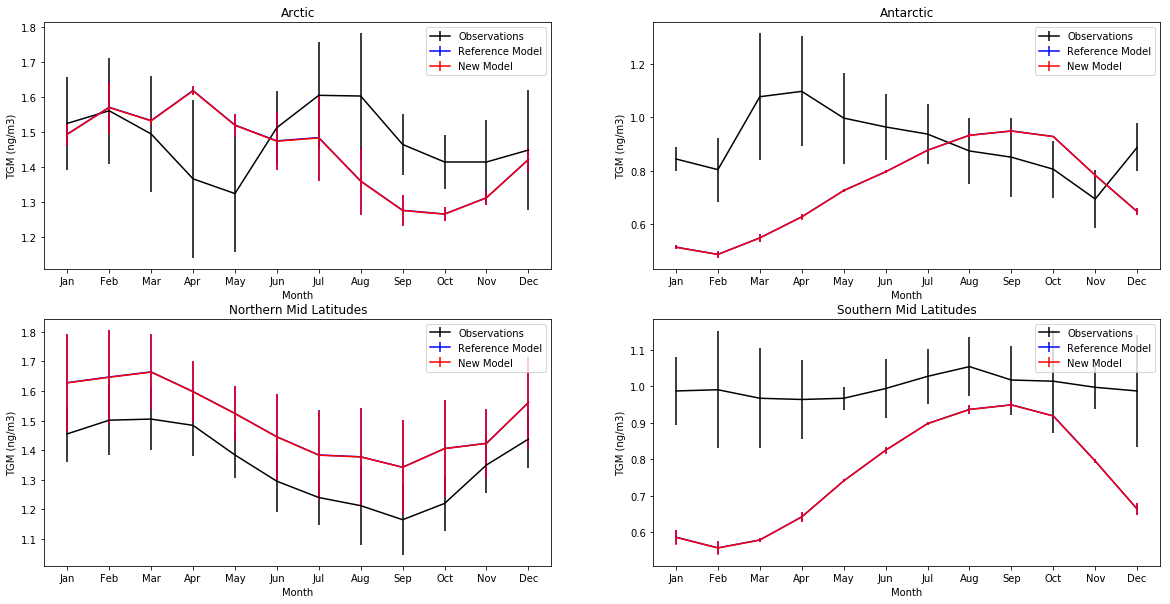

In [21]:
LatitudinalGraphs(OLD_ds, NEW_ds)